In [1]:
import math
import torch.optim as optim
from torch import jit
class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is not None and epoch >= self.start_decay_at:
            self.start_decay = True
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
            print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()

import torch
import numpy as np;
from torch.autograd import Variable
import pandas as pd

def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))

class Data_utility(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, cuda, horizon, window, normalize = 2):
        self.cuda = cuda;
        self.P = window;
        self.h = horizon
        # fin = open(file_name);
        df = pd.read_csv(file_name, header=0, index_col=0)
        # self.rawdat = np.loadtxt(fin,delimiter=',');
        self.rawdat = df.to_numpy()
        self.dat = np.zeros(self.rawdat.shape);
        self.n, self.m = self.dat.shape;
        self.normalize = 2
        self.scale = np.ones(self.m);
        self._normalized(normalize);
        self._split(int(train * self.n), int((train+valid) * self.n), self.n);
        
        self.scale = torch.from_numpy(self.scale).float();
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.m);
            
        if self.cuda:
            self.scale = self.scale.cuda();
        self.scale = Variable(self.scale);
        
        self.rse = normal_std(tmp);
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)));
    
    def _normalized(self, normalize):
        #normalized by the maximum value of entire matrix.
       
        if (normalize == 0):
            self.dat = self.rawdat
            
        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat);
            
        #normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:,i]));
                self.dat[:,i] = self.rawdat[:,i] / np.max(np.abs(self.rawdat[:,i]));
            
        
    def _split(self, train, valid, test):
        
        train_set = range(self.P+self.h-1, train);
        valid_set = range(train, valid);
        test_set = range(valid, self.n);
        print('===========SPLIT DATA')

        self.train = self._batchify(train_set, self.h);
        self.valid = self._batchify(valid_set, self.h);
        self.test = self._batchify(test_set, self.h);
        print(f'TRAIN: {self.train[0].shape}')
        print(f'VAL: {self.valid[0].shape}')
        print(f'TEST: {self.test[0].shape}')
        
        
    def _batchify(self, idx_set, horizon):
        
        n = len(idx_set);
        X = torch.zeros((n,self.P,self.m));
        Y = torch.zeros((n,self.m));
        
        for i in range(n):
            end = idx_set[i] - self.h + 1;
            start = end - self.P;
            X[i,:,:] = torch.from_numpy(self.dat[start:end, :]);
            Y[i,:] = torch.from_numpy(self.dat[idx_set[i], :]);

        return [X, Y];

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]; Y = targets[excerpt];
            if (self.cuda):
                X = X.cuda();
                Y = Y.cuda();  
            yield Variable(X), Variable(Y);
            start_idx += batch_size

import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTNet(nn.Module):
    def __init__(self, args, data):
        super(LSTNet, self).__init__()
        self.use_cuda = args.cuda
        self.P = args.window;
        self.m = data.m
        self.hidR = args.hidRNN;
        self.hidC = args.hidCNN;
        self.hidS = args.hidSkip;
        self.Ck = args.CNN_kernel;
        self.skip = args.skip;
        self.pt = int((self.P - self.Ck)/self.skip)
        self.hw = args.highway_window
        self.conv1 = nn.Conv2d(1, self.hidC, kernel_size = (self.Ck, self.m));
        self.GRU1 = nn.GRU(self.hidC, self.hidR);
        self.dropout = nn.Dropout(p = args.dropout);
        if (self.skip > 0):
            self.GRUskip = nn.GRU(self.hidC, self.hidS);
            self.linear1 = nn.Linear(self.hidR + self.skip * self.hidS, self.m);
        else:
            self.linear1 = nn.Linear(self.hidR, self.m);
        if (self.hw > 0):
            self.highway = nn.Linear(self.hw, 1);
        self.output = None;
        if (args.output_fun == 'sigmoid'):
            self.output = F.sigmoid;
        if (args.output_fun == 'tanh'):
            self.output = F.tanh;
 
    def forward(self, x):
        batch_size = x.size(0);
        
        #CNN
        c = x.view(-1, 1, self.P, self.m);
        c = self.conv1(c)
        c = F.relu(c)
        # c = F.relu(self.conv1(c));
        c = self.dropout(c);
        c = torch.squeeze(c, 3);
        
        # RNN 
        r = c.permute(2, 0, 1).contiguous();
        _, r = self.GRU1(r);
        r = self.dropout(torch.squeeze(r,0));

        
        #skip-rnn
        
        if (self.skip > 0):
            s = c[:,:, int(-self.pt * self.skip):].contiguous();
            s = s.view(batch_size, self.hidC, self.pt, self.skip);
            s = s.permute(2,0,3,1).contiguous();
            s = s.view(self.pt, batch_size * self.skip, self.hidC);
            _, s = self.GRUskip(s);
            s = s.view(batch_size, self.skip * self.hidS);
            s = self.dropout(s);
            r = torch.cat((r,s),1);
        
        res = self.linear1(r);
        
        #highway
        if (self.hw > 0):
            z = x[:, -self.hw:, :];
            z = z.permute(0,2,1).contiguous().view(-1, self.hw);
            z = self.highway(z);
            z = z.view(-1,self.m);
            res = res + z;
            
        if self.output is not None:
            res = self.output(res);
        return res;


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


import argparse
import math
import time

import torch
import torch.nn as nn
import numpy as np;
import importlib

def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval();
    # print('=======X Shape=========')
    # print(X.shape)
    total_loss = 0;
    total_loss_l1 = 0;
    n_samples = 0;
    predict = None;
    test = None;
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X);
        if predict is None:
            predict = output;
            test = Y;
        else:
            predict = torch.cat((predict,output));
            test = torch.cat((test, Y));
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m);
    # rse = math.sqrt(total_loss / n_samples)/data.rse
    rse = math.sqrt(total_loss/n_samples)
    # rae = (total_loss_l1/n_samples)/data.rae
    rae = total_loss_l1/n_samples
    
    predict = predict.data.cpu().numpy();
    Ytest = test.data.cpu().numpy();
    print('VN30 rmse = ', np.sqrt(np.mean((predict[:, -1] - Ytest[:, -1])**2)))
    sigma_p = (predict).std(axis = 0);
    sigma_g = (Ytest).std(axis = 0);
    mean_p = predict.mean(axis = 0)
    mean_g = Ytest.mean(axis = 0)
    index = (sigma_g!=0);
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis = 0)/(sigma_p * sigma_g + 0.000000000000001);
    correlation = (correlation[index]).mean();
    return rse, rae, correlation;

def train(data, X, Y, model, criterion, optim, batch_size):
    model.train();
    total_loss = 0;
    n_samples = 0;
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad();
        output = model(X);
        scale = data.scale.expand(output.size(0), data.m)
        loss = criterion(output * scale, Y * scale);
        loss.backward();
        grad_norm = optim.step();
        total_loss += loss.item();
        n_samples += (output.size(0) * data.m);
    return total_loss / n_samples
    
parser = argparse.ArgumentParser(description='PyTorch Time series forecasting')
parser.add_argument('--data', type=str, default="data/exchange_rate/exchange_rate.txt",
                    help='location of the data file')
parser.add_argument('--model', type=str, default='LSTNet',
                    help='')
parser.add_argument('--hidCNN', type=int, default=100,
                    help='number of CNN hidden units')
parser.add_argument('--hidRNN', type=int, default=100,
                    help='number of RNN hidden units')
parser.add_argument('--window', type=int, default=24 * 7,
                    help='window size')
parser.add_argument('--CNN_kernel', type=int, default=6,
                    help='the kernel size of the CNN layers')
parser.add_argument('--highway_window', type=int, default=24,
                    help='The window size of the highway component')
parser.add_argument('--clip', type=float, default=10.,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=100,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=128, metavar='N',
                    help='batch size')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--seed', type=int, default=54321,
                    help='random seed')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--log_interval', type=int, default=2000, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str,  default='model/model.pt',
                    help='path to save the final model')
parser.add_argument('--cuda', type=str, default=True)
parser.add_argument('--optim', type=str, default='adam')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--horizon', type=int, default=1)
parser.add_argument('--skip', type=float, default=24)
parser.add_argument('--hidSkip', type=int, default=5)
parser.add_argument('--L1Loss', type=bool, default=True)
parser.add_argument('--normalize', type=int, default=2)
parser.add_argument('--output_fun', type=str, default='sigmoid')
# args = parser.parse_args()
args = dotdict()
args.data = 'VN30_price.csv'
args.model = 'LSTNet'
args.hidCNN = 50
args.hidRNN = 50
args.window = 100
args.CNN_kernel = 6
args.highway_window = 24
args.clip = 10.
args.epochs = 10000
args.batch_size = 128
args.dropout = 0.2
args.seed = 54321
args.gpu = None
args.log_interval = 2000
args.save = 'LSTNet_multistock.pt'
args.cuda = False
args.optim = 'adam'
args.lr = 0.001
args.horizon = 1
args.skip = 24
args.hidSkip = 5
args.L1Loss = False
args.normalize = 0
args.output_fun = None
args.cuda = args.gpu is not None
if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

Data = Data_utility(args.data, 0.6, 0.2, args.cuda, args.horizon, args.window, args.normalize);
print(Data.rse);

model = LSTNet(args, Data);

if args.cuda:
    model.cuda()
    
nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)

if args.L1Loss:
    criterion = nn.L1Loss(size_average=False);
else:
    criterion = nn.MSELoss(size_average=False);
evaluateL2 = nn.MSELoss(size_average=False);
evaluateL1 = nn.L1Loss(size_average=False)
if args.cuda:
    criterion = criterion.cuda()
    evaluateL1 = evaluateL1.cuda();
    evaluateL2 = evaluateL2.cuda();
    
    
best_val = 10000000;
optim = Optim(
    model.parameters(), args.optim, args.lr, args.clip,
)

# At any point you can hit Ctrl + C to break out of training early.
try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, args.batch_size)
        val_loss, val_rae, val_corr = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
          net_trace = jit.script(model)
          jit.save(net_trace, "LSTNet_VN30.pt")
          with open(args.save, 'wb') as f:
            torch.save(model, f)
          best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))


===========SPLIT DATA
TRAIN: torch.Size([800, 100, 22])
VAL: torch.Size([300, 100, 22])
TEST: torch.Size([300, 100, 22])
tensor(31435.6816)
* number of parameters: 26592
begin training


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
VN30 rmse =  16.922085
| end of epoch 7919 | time:  0.83s | train_loss 1083944.2364 | valid rse 1061.6407 | valid rae 655.9490 | valid corr  0.9888
VN30 rmse =  16.920578
| end of epoch 7920 | time:  0.84s | train_loss 1077538.1527 | valid rse 1061.4991 | valid rae 654.5176 | valid corr  0.9888
VN30 rmse =  19.71129
test rse 1457.1158 | test rae 920.7620 | test corr 0.9810
VN30 rmse =  17.666353
| end of epoch 7921 | time:  0.83s | train_loss 1072219.4873 | valid rse 1083.3979 | valid rae 670.5368 | valid corr  0.9888
VN30 rmse =  20.493963
| end of epoch 7922 | time:  0.83s | train_loss 1077467.4327 | valid rse 1174.4036 | valid rae 755.6535 | valid corr  0.9888
VN30 rmse =  19.05005
| end of epoch 7923 | time:  0.84s | train_loss 1183474.8727 | valid rse 1126.3368 | valid rae 732.3663 | valid corr  0.9888
VN30 rmse =  16.94388
| end of epoch 7924 | time:  0.84s | train_loss 1139784.2036 | valid rse 1061.9256 | valid rae 653.9840 | va

In [2]:
with open(args.save, 'rb') as f:
    model = torch.load(f)
model.eval()

LSTNet(
  (conv1): Conv2d(1, 50, kernel_size=(6, 22), stride=(1, 1))
  (GRU1): GRU(50, 50)
  (dropout): Dropout(p=0.2, inplace=False)
  (GRUskip): GRU(50, 5)
  (linear1): Linear(in_features=170, out_features=22, bias=True)
  (highway): Linear(in_features=24, out_features=1, bias=True)
)

In [3]:
Data.test[0].size()

torch.Size([300, 100, 22])

In [4]:
pred = model(Data.test[0])


In [5]:
scale = Data.scale.expand(pred.size(0), Data.m)

In [6]:
pred_y = (pred * scale).detach().numpy()[:, -1]

In [7]:
true_y = (Data.test[1] * scale).detach().numpy()[:, -1]

In [8]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [9]:
print('\nForecast Accuracy of LSTNet: VN30')
accuracy_prod = forecast_accuracy(true_y, pred_y)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of LSTNet: VN30
mape   :  0.0112
me     :  -3.3044
mae    :  14.1026
mpe    :  -0.0025
rmse   :  19.6988
corr   :  0.995
minmax :  0.0111


In [16]:
pred_y

array([1489.1891 , 1489.9209 , 1479.7115 , 1484.6711 , 1518.9275 ,
       1531.5386 , 1534.3811 , 1519.059  , 1523.3647 , 1531.6377 ,
       1530.171  , 1533.768  , 1535.9471 , 1529.0879 , 1525.5172 ,
       1516.9539 , 1530.0531 , 1530.6272 , 1518.8871 , 1521.2249 ,
       1505.7944 , 1500.3943 , 1518.1404 , 1536.8042 , 1566.9656 ,
       1574.8368 , 1569.2803 , 1555.0205 , 1539.8119 , 1550.1525 ,
       1542.0006 , 1504.5367 , 1480.1985 , 1515.0952 , 1519.4019 ,
       1531.4851 , 1522.6985 , 1522.7609 , 1519.6842 , 1520.8893 ,
       1511.8812 , 1513.3171 , 1514.5205 , 1512.5702 , 1506.5314 ,
       1479.73   , 1508.6694 , 1517.695  , 1526.3622 , 1517.7676 ,
       1519.6727 , 1538.4943 , 1561.0635 , 1547.5754 , 1544.239  ,
       1534.8345 , 1515.5332 , 1500.9238 , 1532.019  , 1528.348  ,
       1523.8181 , 1480.8818 , 1479.301  , 1485.0746 , 1493.9312 ,
       1505.0128 , 1471.9341 , 1517.6562 , 1528.9657 , 1518.5115 ,
       1534.6337 , 1543.9667 , 1551.7975 , 1553.1661 , 1553.42

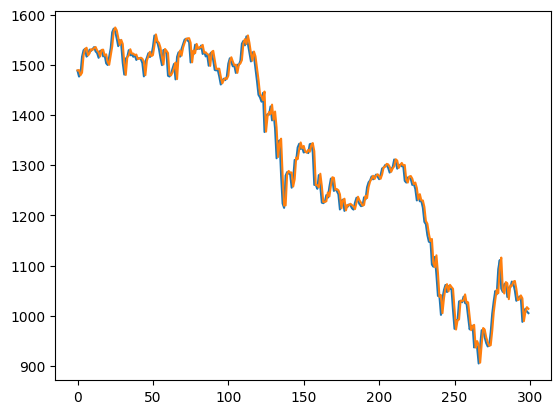

<Figure size 3000x1500 with 0 Axes>

In [15]:
from matplotlib import pyplot as plt
plt.plot(true_y, label="True")
plt.plot(pred_y, label='Predicted - Test')
plt.figure(figsize=(30,15))
plt.show()

In [11]:
# from torch import jit
# net_trace = jit.script(model)
# jit.save(net_trace, "LSTNet_VN30.pt")

In [ ]:
while True:
  pass